### Statistical Analysis of Simulations and Gaia DR3


In [1]:
import glob
from rad_vel_analysis import *

In [2]:
base_dir = "stage_M2_OHP/spades2/Results"
sim_files = glob.glob(f"{base_dir}/Results_SIM_*/results_snr*/Spades2RadialVelocities_snr*.txt")

| Simulation | Convolution | Stoch. Resampling | Pixel Size | SNRs                        | Notes                                                                 |
|------------|-------------|-------------------|------------|-----------------------------|-----------------------------------------------------------------------|
| SIM_01     | yes         | no                | 0.25 Å     | 2, 5, 25, 50, 150           | No stochastic resampling; no input R param in convolution            |
| SIM_02     | yes         | yes               | 0.25 Å     | 2, 5, 25, 50, 150           | First simulation with stochastic resampling; reduced wavelength range |
| SIM_03     | yes         | yes               | 0.25 Å     | 2, 5, 25, 50, 150           | Same as SIM_02; clean baseline                                       |
| SIM_04     | yes         | yes               | 0.25 Å     | 2.6, 4.9, 24.2, 48.2, 144.3 | SNRs matched to Gaia bin means                                       |
| SIM_05     | yes         | yes               | 0.25 Å     | 2.6, 144.3                  | Only faint + bright ends; normalization disabled in SPADES config    |


### GaiaNIR Sims

In [3]:
def calibrate_sim_df(sim_df, calibration_value=0.113):
    df = sim_df.copy()
    df["disp_cal"] = np.sqrt(df["disp"]**2 + calibration_value**2)
    df["disp_low_cal"] = df["disp_low"] * (df["disp"] / df["disp_cal"])
    df["disp_upp_cal"] = df["disp_upp"] * (df["disp"] / df["disp_cal"])
    return df


In [4]:
def load_simulation(sim_name, sim_files, calibration_value=0.113):
    sim_df = load_simulation_data(sim_name, sim_files) 
    sim_df_calibrated = calibrate_simulation_data(sim_df, calibration_value)
    return sim_df, sim_df_calibrated


In [5]:
sim_names = ["Results_SIM_03", "Results_SIM_04", "Results_SIM_05"]

sim_data_dict = {}
sim_calibrated_dict = {}

for sim_name in sim_names:
    sim_df = load_simulation_data(sim_name, sim_files)
    sim_data_dict[sim_name] = sim_df
    sim_calibrated_dict[sim_name] = calibrate_sim_df(sim_df)


In [111]:
display(sim_data_dict["Results_SIM_04"].drop(columns=["path"]))

,simulation,snr,disp,disp_low,disp_upp,median,med_low,med_upp,n
0,Results_SIM_04,2,5.246085,-0.214892,0.236265,-0.1880,-0.198070,0.217769,1000
1,Results_SIM_04,4,2.566110,-0.117456,0.103226,0.0470,-0.108262,0.095145,1000
2,Results_SIM_04,24,0.584793,-0.024852,0.025440,-0.0130,-0.022906,0.023448,1000
3,Results_SIM_04,48,0.286158,-0.012741,0.011868,-0.0280,-0.011744,0.010939,1000
4,Results_SIM_04,144,0.091159,-0.004178,0.003662,0.0015,-0.003851,0.003375,1000


In [112]:
display(sim_data_dict["Results_SIM_05"].drop(columns=["path"]))

,simulation,snr,disp,disp_low,disp_upp,median,med_low,med_upp,n
0,Results_SIM_05,2,5.116427,-0.203665,0.236341,-0.3615,-0.187722,0.217839,1000
1,Results_SIM_05,144,0.090000,-0.003977,0.003762,0.0585,-0.003666,0.003468,1000


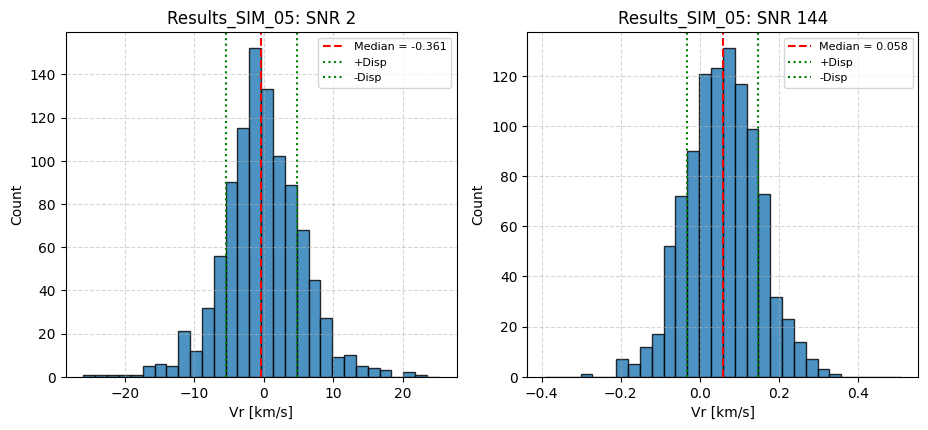

In [102]:
plot_histograms_from_dict("Results_SIM_05", sim_data_dict)

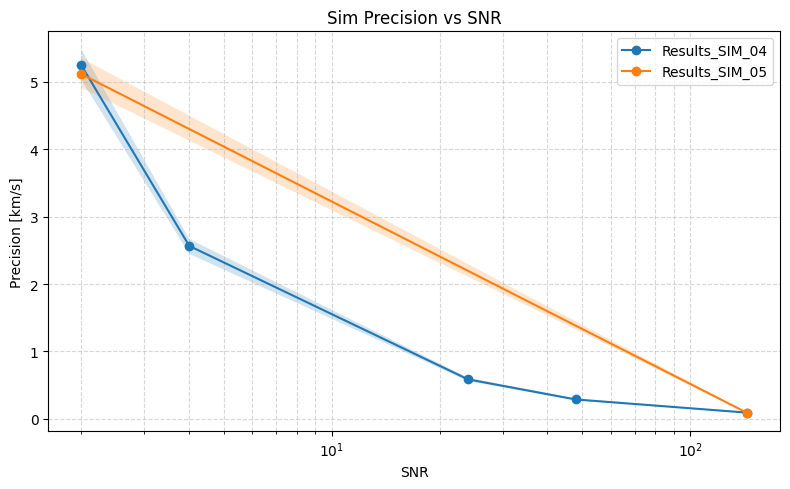

In [119]:
#PRECISION VS SNR 

selected_sims = ["Results_SIM_04","Results_SIM_05"]
apply_calibration = False 

plt.figure(figsize=(8, 5))

for sim_key in selected_sims:
    # Sim 
    plt.plot(sim_data_dict[sim_key]["snr"],
             sim_data_dict[sim_key]["disp"],
             marker='o', linestyle='-', label=f"{sim_key}")
    
    plt.fill_between(sim_data_dict[sim_key]["snr"],
                     np.array(sim_data_dict[sim_key]["disp"]) + np.array(sim_data_dict[sim_key]["disp_low"]),
                     np.array(sim_data_dict[sim_key]["disp"]) + np.array(sim_data_dict[sim_key]["disp_upp"]),
                     alpha=0.2)
    
    if apply_calibration:
        # Sim + Cali
        plt.plot(sim_calibrated_dict[sim_key]["snr"],
                sim_calibrated_dict[sim_key]["disp_cal"],
                marker='s', linestyle='--',color='purple', label=f"{sim_key} + Cali")
        
        plt.fill_between(sim_calibrated_dict[sim_key]["snr"],
                        sim_calibrated_dict[sim_key]["disp_cal"] - np.abs(sim_calibrated_dict[sim_key]["disp_low_cal"]),
                        sim_calibrated_dict[sim_key]["disp_cal"] + np.abs(sim_calibrated_dict[sim_key]["disp_upp_cal"]),
                        color='purple',alpha=0.5)

#plt.yscale("log")
plt.xscale("log")
plt.xlabel("SNR")
plt.ylabel("Precision [km/s]")
plt.title("Sim Precision vs SNR")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


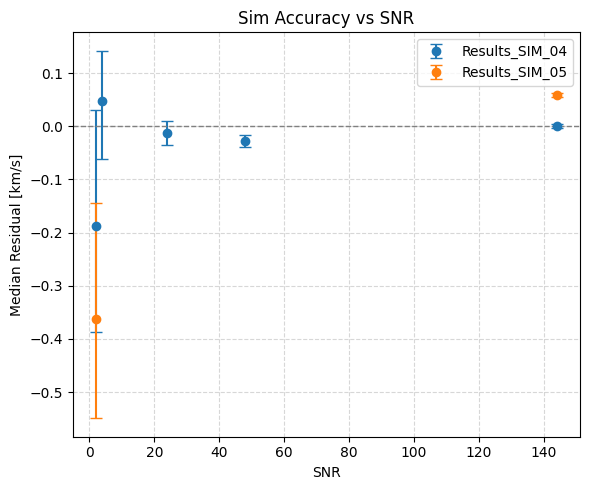

In [120]:
#ACCURACY PLOT
selected_sims = ["Results_SIM_04", "Results_SIM_05"]

plt.figure(figsize=(6, 5))

for sim_key in selected_sims:
    df = sim_data_dict[sim_key]
    
    plt.errorbar(df["snr"], df["median"],
                 yerr=[np.abs(df["med_low"]), np.abs(df["med_upp"])],
                 fmt='o', capsize=4, label=f"{sim_key}")

plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.xlabel("SNR")
plt.ylabel("Median Residual [km/s]")
plt.title("Sim Accuracy vs SNR")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Gaia DR3

In [ ]:
gaia_all_df = load_gaia("gaiadata/gaia_rvs.parquet")
gaia_filtered_df = gaia_all_df[gaia_all_df["rv_atm_param_origin"] >= 1]

print(f"Total Gaia DR3 spectra: {len(gaia_all_df)}")
print(f"Filtered (rv_atm_param_origin >= 1): {len(gaia_filtered_df)}")

Total Gaia DR3 spectra: 13993311
Filtered (rv_atm_param_origin >= 1): 9978210


In [106]:
snr_bins = [(2, 3), (4, 6), (20, 30), (40, 60), (125, 175)]
#snr_bins = [(2, 3), (125, 175)]

gaia_stats_df = summarize_gaia_uncertainty(gaia_all_df, snr_bins)
display(gaia_stats_df)

,snr,median_error,med_low,med_upp,count,snr_range
0,2.611872,8.180306,-0.003602,0.005856,601858,2-3
1,4.964256,5.684453,-0.001011,0.001609,3935450,4-6
2,24.132793,1.230666,-0.000581,0.001093,691853,20-30
3,48.217307,0.541340,-0.000415,0.001591,211556,40-60
4,144.333490,0.192260,-0.000296,0.003167,17616,125-175


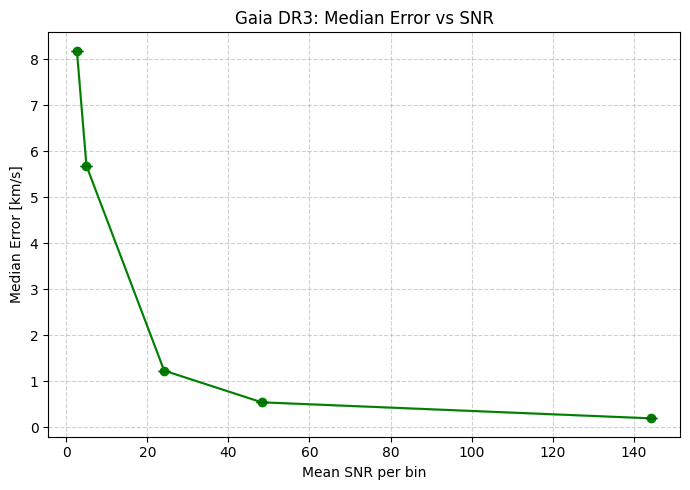

In [107]:
# Median error vs SNR 
plt.figure(figsize=(7, 5))

gaia_snr = gaia_stats_df["snr"].values                          
gaia_median_error = gaia_stats_df["median_error"].values       
gaia_low = np.abs(gaia_stats_df["med_low"].values)             
gaia_upp = np.abs(gaia_stats_df["med_upp"].values)                   


plt.plot(gaia_snr, gaia_median_error, marker='o', color='green', label="Median Error")
plt.fill_between(gaia_snr,
                 gaia_median_error + gaia_low,
                 gaia_median_error + gaia_upp,
                 color='green', alpha=0.2)

plt.errorbar(gaia_snr, gaia_median_error,
             yerr=[gaia_low, gaia_upp],
             fmt='none', ecolor='darkgreen', capsize=4, linewidth=1.2)

plt.xlabel("Mean SNR per bin")
plt.ylabel("Median Error [km/s]")
plt.title("Gaia DR3: Median Error vs SNR")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

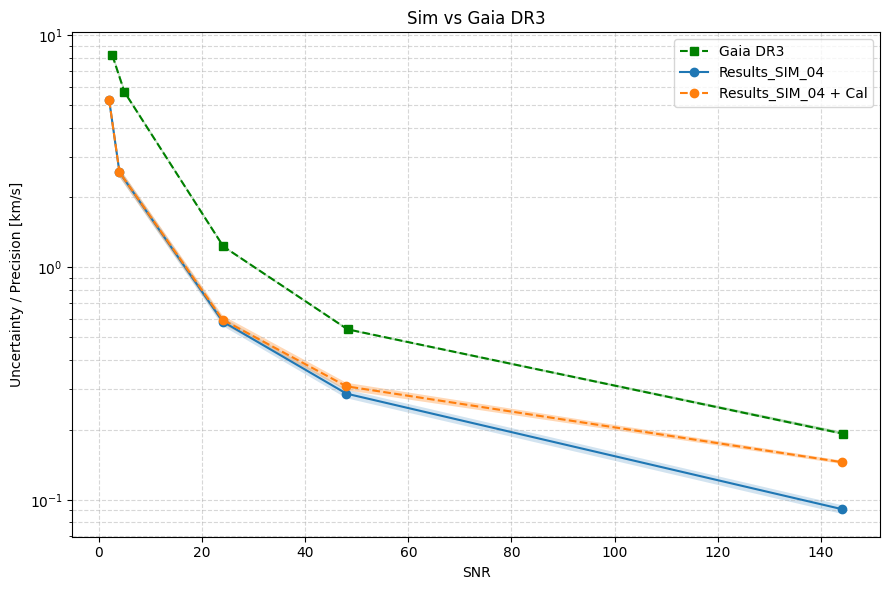

In [ ]:
selected_sims = ["Results_SIM_04"]
apply_calibration = True 

gaia_snr = gaia_stats_df["snr"].values
gaia_median_err = gaia_stats_df["median_error"].values
gaia_low = gaia_stats_df["med_low"].values
gaia_upp = gaia_stats_df["med_upp"].values

plt.figure(figsize=(9, 6))

# Gaia
plt.plot(gaia_snr, gaia_median_err, marker='s', linestyle='--', color='green', label="Gaia DR3", zorder=3)
plt.fill_between(gaia_snr,
                 gaia_median_err - np.abs(gaia_low),
                 gaia_median_err + np.abs(gaia_upp),
                 color='green', alpha=0.2, zorder=1)


for sim_key in selected_sims:
    sim_df = sim_data_dict[sim_key]
    sim_df_cal = sim_calibrated_dict[sim_key]

    # Sim
    plt.plot(sim_df["snr"], sim_df["disp"], marker='o', linestyle='-', label=f"{sim_key}", zorder=2)
    plt.fill_between(sim_df["snr"],
                     sim_df["disp"] - np.abs(sim_df["disp_low"]),
                     sim_df["disp"] + np.abs(sim_df["disp_upp"]),
                     alpha=0.2, zorder=1)
    
    if apply_calibration:

        # Sim + Cali
        plt.plot(sim_df_cal["snr"], sim_df_cal["disp_cal"], marker='o', linestyle='--', label=f"{sim_key} + Cal", zorder=2)
        plt.fill_between(sim_df_cal["snr"],
                        sim_df_cal["disp_cal"] - np.abs(sim_df_cal["disp_low_cal"]),
                        sim_df_cal["disp_cal"] + np.abs(sim_df_cal["disp_upp_cal"]),
                        alpha=0.3, zorder=1)

plt.yscale("log")
plt.xlabel("SNR")
plt.ylabel("Uncertainty / Precision [km/s]")
plt.title("Sim vs Gaia DR3")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()7
